In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import RBF
import sys
sys.path.append("/home/leon/projects/gaussian_process/")
from gaussian_process_visualisation import visualise_1D_gaussian_process, visualise_2D_gaussian_process
from gaussian_process_hyperparameter_tuning import optimise_hyperparameters


In [2]:
path = "/home/leon/learning/gaussian-processes/bank/bank-full.csv"
data = pd.read_csv(path, sep=";")
one_hot_encode = ["job", "marital", "education", "contact", "poutcome", "month"]
binary = ["default", "housing", "loan", "y"]

In [3]:
enc = OneHotEncoder()

In [4]:
def yesNoBinary(column):
    return(pd.DataFrame([1 if value == "yes" else 0 for value in column], columns = [column.name]))

In [5]:
one_hot = pd.DataFrame(enc.fit_transform(data[one_hot_encode]).toarray(), columns=enc.get_feature_names_out(one_hot_encode))

In [6]:
data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)

/tmp/ipykernel_13506/194164172.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)
/tmp/ipykernel_13506/194164172.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data2 = pd.concat([one_hot] + [ yesNoBinary(data[col]) if col in binary else data[col] for col in data.columns ], 1).drop(one_hot_encode, 1)


In [52]:
data2.shape

(45211, 49)

In [56]:
X, y = data2.values[:,:-1], data2.values[:,-1]

In [8]:
hyperparameters = [
    [("weights", ['uniform', 'distance'])],
    [("n_neighbors", np.arange(4, 100, 1)),
     ("leaf_size", np.arange(5, 100, 5))]
]

In [59]:
kernel = RBF(1.0)
(best_configurations, best_scores), gp_datas = optimise_hyperparameters(KNeighborsClassifier, hyperparameters, 100, X, y, 10, kernel=kernel)

/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/leon/miniconda3/envs/dev/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown 

In [34]:
from sklearn.model_selection import RandomizedSearchCV
classifier = KNeighborsClassifier()
gs = RandomizedSearchCV(classifier, {"weights": ["uniform", "distance"], "n_neighbors": np.arange(4, 100, 1), "leaf_size": np.arange(5, 100, 5)}, n_iter=500)
gs.fit(X, y)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95]),
                         'n_neighbors': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
       89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                         'weights': ['uniform', 'distance']})

In [60]:
from sklearn.model_selection import cross_val_score

knn_bayes = KNeighborsClassifier(**best_configurations[0])
score_bayes = np.mean(cross_val_score(knn_bayes, X, y, cv=5))

knn_gs = KNeighborsClassifier(**gs.best_params_)
score_gs = np.mean(cross_val_score(knn_gs, X, y, cv=5))

knn_default = KNeighborsClassifier()
score_default = np.mean(cross_val_score(knn_default, X, y, cv=5))
print(f"bayesian: {score_bayes}, grid search: {score_gs}, default: {score_default}")


bayesian: 0.8813339364142461, grid search: 0.8786574689000325, default: 0.8723093672021383


In [45]:
print(f"number of samples taken with grid search: {2*len(np.arange(4, 100, 1))*len(np.arange(5, 100, 5))}")

number of samples taken with grid search: 3648


In [47]:
print(f'number of samples taken with bayesian optimisation: {gp_datas["distance"][0].shape[0] + gp_datas["uniform"][0].shape[0]}')

number of samples taken with bayesian optimisation: 500


In [40]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.utils.extmath import cartesian
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

gaussian = GaussianProcessRegressor(kernel=kernel)
#gaussian.fit(result['uniform'][0], result['uniform'][0].dot(np.array([1.0, 3.0]))/500)
gaussian.fit(gp_datas['distance'][0], gp_datas['distance'][1])

GaussianProcessRegressor(kernel=RBF(length_scale=1))

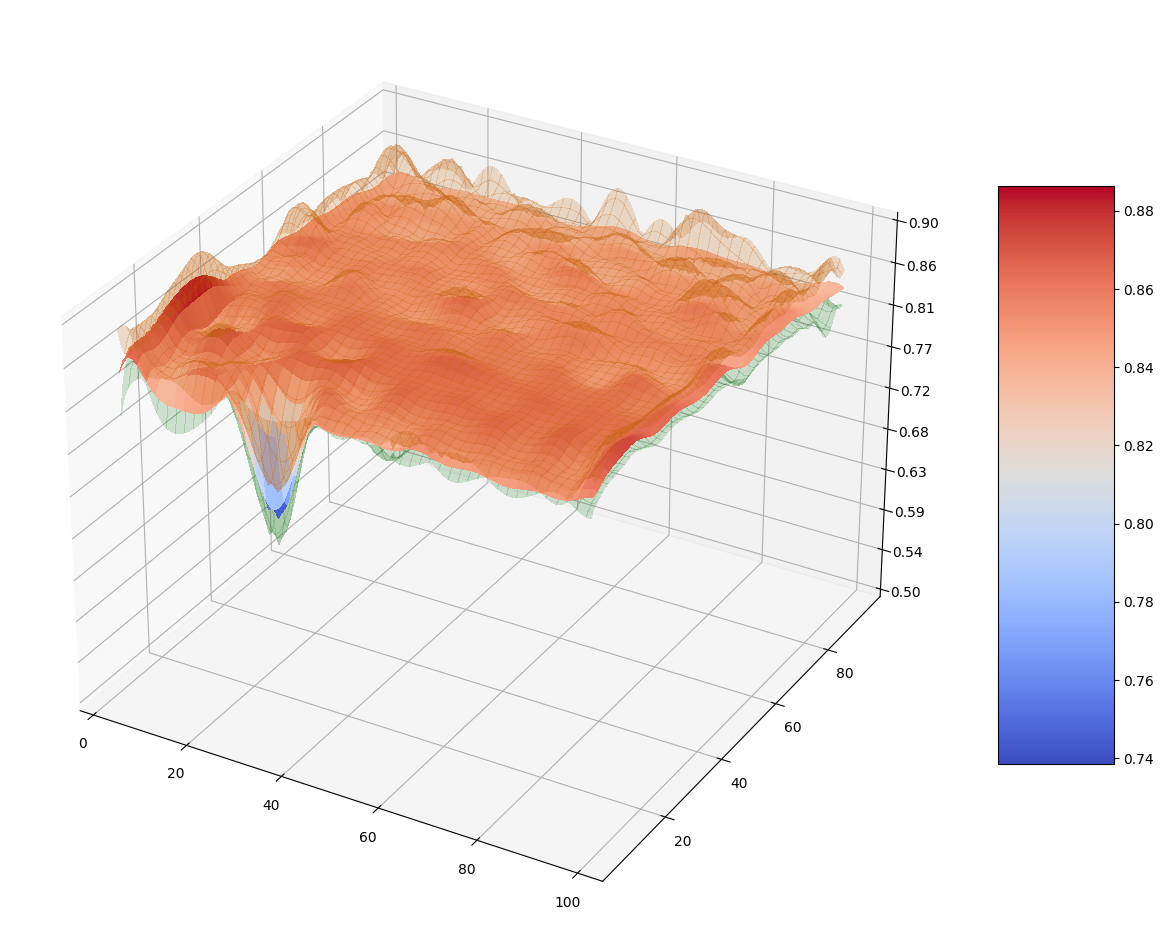

In [41]:
visualise_2D_gaussian_process(gaussian, np.arange(4, 100, 1), np.arange(5, 100, 5), np.arange(0.5, 1, 0.1))